In [5]:
import pandas as pd

In [8]:
df = pd.read_csv('metadata.csv')

# Define columns to exclude (attributes to avoid)
columns_to_exclude = ['patient_id', 'lesion_id', 'age', 'background_mother', 'background_father', 'gender', 'img_id', 'region', 'biopsed']

# Filter the dataframe to exclude unwanted columns while keeping 'diagnostic' as target
df = df.drop(columns=[col for col in columns_to_exclude if col in df.columns])

print("Dataset shape after removing excluded attributes:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nColumns remaining in dataset:")
print(df.columns.tolist())


Dataset shape after removing excluded attributes: (2298, 17)

First few rows:
   smoke  drink pesticide skin_cancer_history cancer_history has_piped_water  \
0    NaN    NaN       NaN                 NaN            NaN             NaN   
1  False  False     False                True           True            True   
2    NaN    NaN       NaN                 NaN            NaN             NaN   
3    NaN    NaN       NaN                 NaN            NaN             NaN   
4  False   True     False                True          False           False   

  has_sewage_system  fitspatrick  diameter_1  diameter_2 diagnostic   itch  \
0               NaN          NaN         NaN         NaN        NEV  FALSE   
1              True          3.0         6.0         5.0        BCC   TRUE   
2               NaN          NaN         NaN         NaN        ACK   TRUE   
3               NaN          NaN         NaN         NaN        ACK   TRUE   
4             False          1.0         5.0       

Null Value Visualization

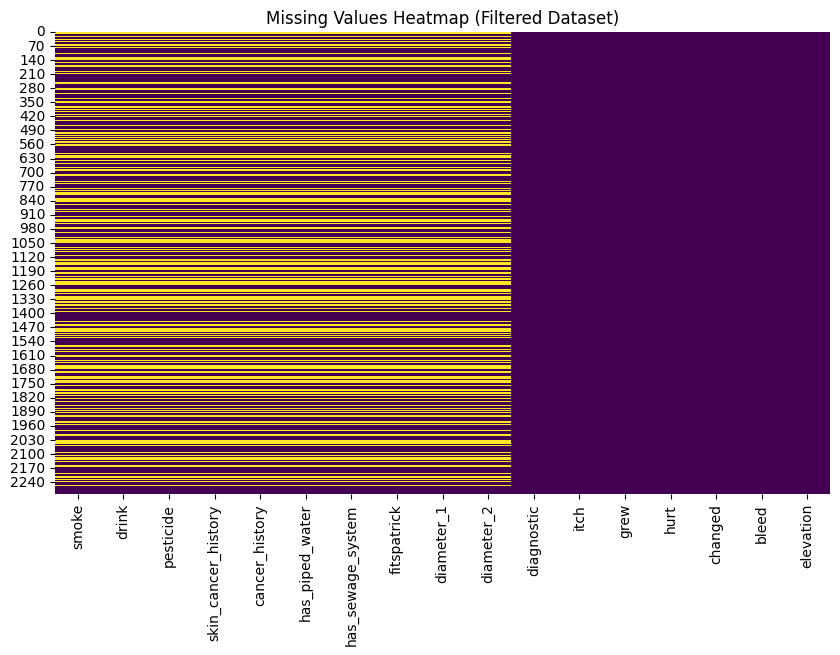

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create plots directory if it doesn't exist
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap (Filtered Dataset)")
plt.savefig("plots/missing_values_filtered.png")
plt.show()

In [10]:
# Drop rows with null values
print("Dataset shape before dropping null values:", df.shape)
df = df.dropna()
print("Dataset shape after dropping null values:", df.shape)
print("\nRemaining null values per column:")
print(df.isnull().sum())


Dataset shape before dropping null values: (2298, 17)
Dataset shape after dropping null values: (1494, 17)

Remaining null values per column:
smoke                  0
drink                  0
pesticide              0
skin_cancer_history    0
cancer_history         0
has_piped_water        0
has_sewage_system      0
fitspatrick            0
diameter_1             0
diameter_2             0
diagnostic             0
itch                   0
grew                   0
hurt                   0
changed                0
bleed                  0
elevation              0
dtype: int64


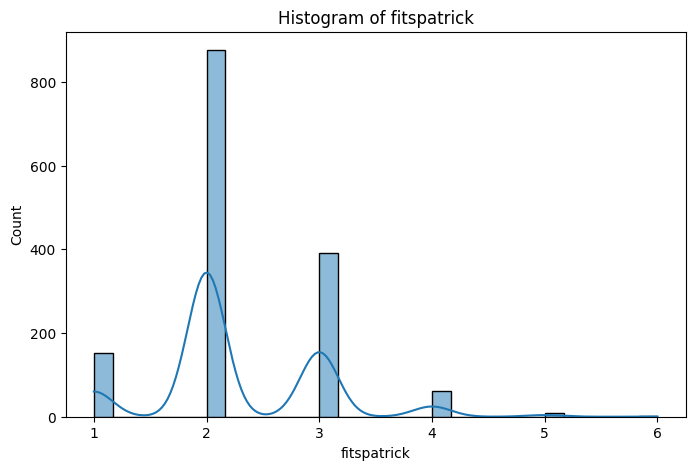

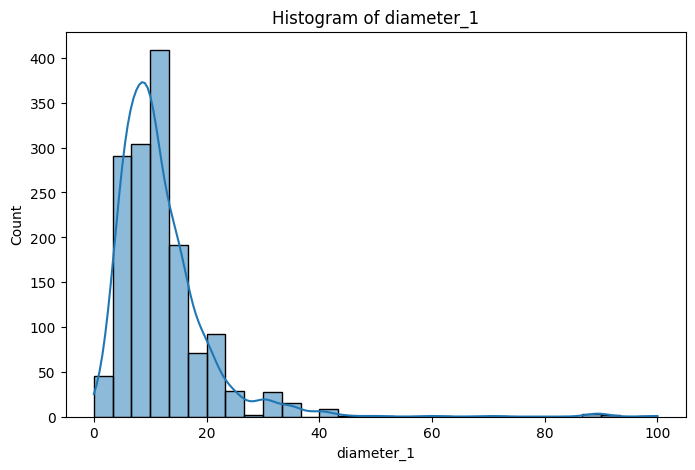

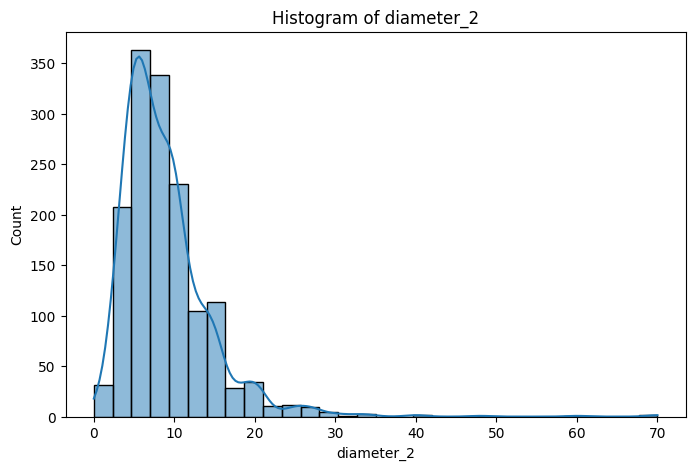

In [11]:
# Select only numerical columns from the filtered dataset (excluding unwanted attributes)
num_cols = df.select_dtypes(include=["int64","float64"]).columns

for col in num_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Histogram of {col}")
    plt.savefig(f"plots/histogram_{col}.png")
    plt.show()

Excluded columns: []
Numerical columns for analysis: ['fitspatrick', 'diameter_1', 'diameter_2']


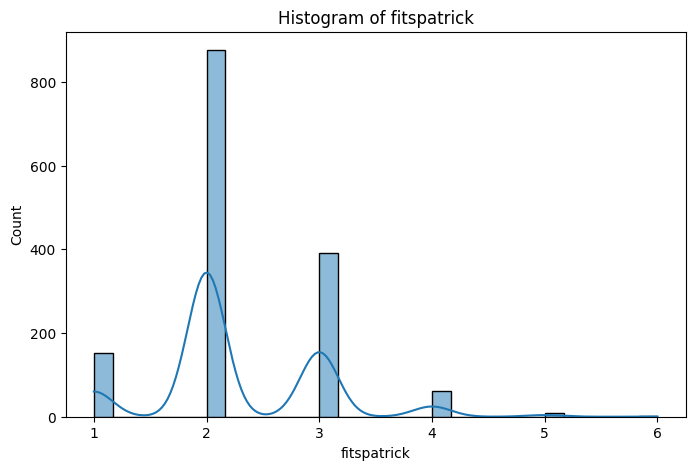

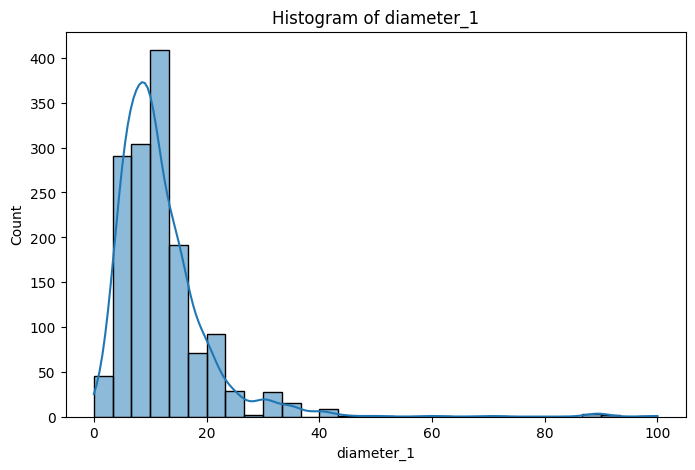

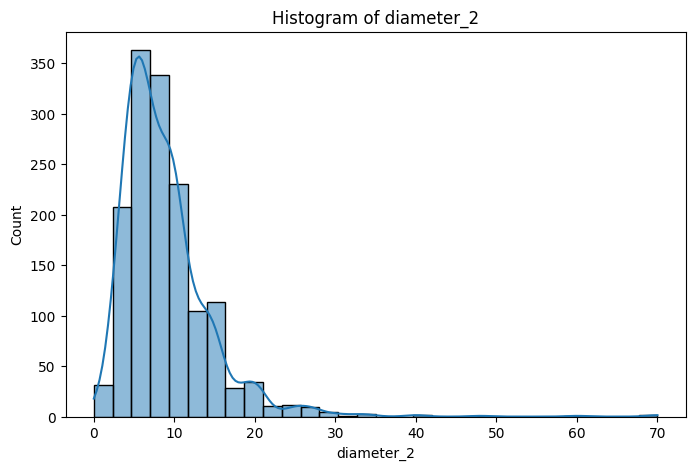

In [12]:
# Exclude unwanted attributes from analysis
unwanted_attrs = ['Patient id', 'Lesion id', 'age', 'Background mother', 'Background Father', 
                  'Gender', 'Img id', 'region', 'biposed']

# Filter out unwanted columns from numerical analysis
available_unwanted = [col for col in unwanted_attrs if col in df.columns]
num_cols = df.select_dtypes(include=["int64","float64"]).columns
num_cols = [col for col in num_cols if col not in unwanted_attrs]

print(f"Excluded columns: {available_unwanted}")
print(f"Numerical columns for analysis: {list(num_cols)}")

for col in num_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Histogram of {col}")
    plt.savefig(f"plots/histogram_{col}.png")
    plt.show()

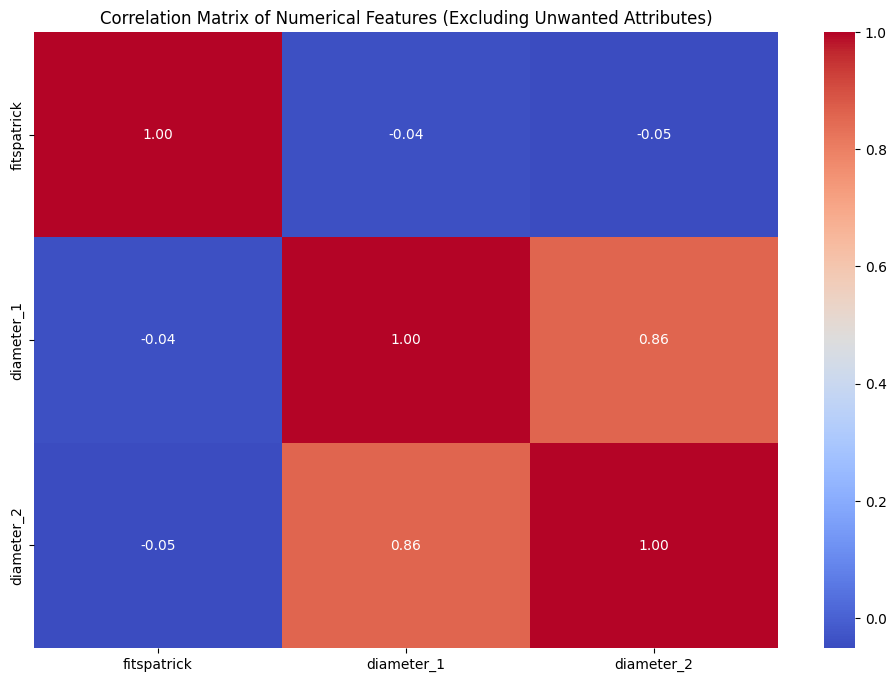

In [19]:
# Create correlation matrix excluding unwanted attributes
# First, create a subset of data excluding unwanted attributes but keeping the target variable
unwanted_attrs = ['Patient id', 'Lesion id', 'age', 'Background mother', 'Background Father', 
                  'Gender', 'Img id', 'region', 'biposed']

# Get all columns except unwanted attributes, but keep diagnostic
cols_for_corr = [col for col in df.columns if col not in unwanted_attrs]
df_filtered = df[cols_for_corr]

# Select only numerical columns from the filtered dataset
num_cols_filtered = df_filtered.select_dtypes(include=["int64","float64"]).columns

plt.figure(figsize=(12,8))
corr = df_filtered[num_cols_filtered].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features (Excluding Unwanted Attributes)")
plt.savefig("plots/correlation_matrix.png")
plt.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

# Prepare the data for maximum accuracy
# First, let's handle categorical variables properly
df_processed = df.copy()

# Define unwanted attributes to exclude
unwanted_attrs = ['Patient id', 'Lesion id', 'age', 'Background mother', 'Background Father', 
                  'Gender', 'Img id', 'region', 'biposed']

# Remove unwanted attributes from the dataset while keeping the target variable 'diagnostic'
columns_to_keep = [col for col in df_processed.columns if col not in unwanted_attrs]
df_processed = df_processed[columns_to_keep]

print(f"Removed attributes: {[attr for attr in unwanted_attrs if attr in df.columns]}")
print(f"Remaining columns: {list(df_processed.columns)}")

# Encode categorical variables
categorical_cols = df_processed.select_dtypes(include=['object', 'bool']).columns
categorical_cols = categorical_cols.drop('diagnostic')  # Remove target variable

label_encoders = {}
for col in categorical_cols:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col].astype(str))
        label_encoders[col] = le

# Feature (X) and Target (y) separation
X = df_processed.drop("diagnostic", axis=1)
y = df_processed["diagnostic"]

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Feature scaling for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Optimized train-test split for maximum accuracy
# Using 70-30 split for better training data, stratified sampling for balanced classes
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, 
    test_size=0.3, 
    random_state=42, 
    stratify=y_encoded
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())
print("Class distribution in testing set:")
print(pd.Series(y_test).value_counts())
print("Feature columns:", list(X.columns))

Removed attributes: []
Remaining columns: ['smoke', 'drink', 'pesticide', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2', 'diagnostic', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation']
Training set shape: (1045, 16)
Testing set shape: (449, 16)
Class distribution in training set:
1    591
0    198
4    134
3     53
2     36
5     33
Name: count, dtype: int64
Class distribution in testing set:
1    254
0     85
4     58
3     22
2     16
5     14
Name: count, dtype: int64
Feature columns: ['smoke', 'drink', 'pesticide', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation']


model Start


Logistic Regression Accuracy: 0.6726057906458798

Classification Report:
              precision    recall  f1-score   support

         ACK       0.65      0.62      0.64        85
         BCC       0.69      0.93      0.79       254
         MEL       0.33      0.12      0.18        16
         NEV       0.58      0.32      0.41        22
         SCC       1.00      0.02      0.03        58
         SEK       0.50      0.14      0.22        14

    accuracy                           0.67       449
   macro avg       0.63      0.36      0.38       449
weighted avg       0.70      0.67      0.61       449



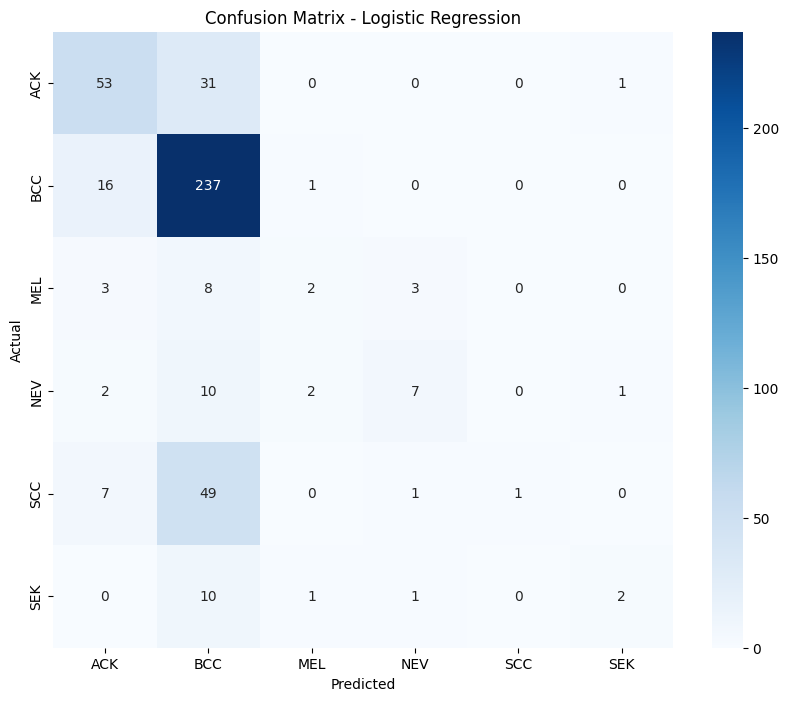

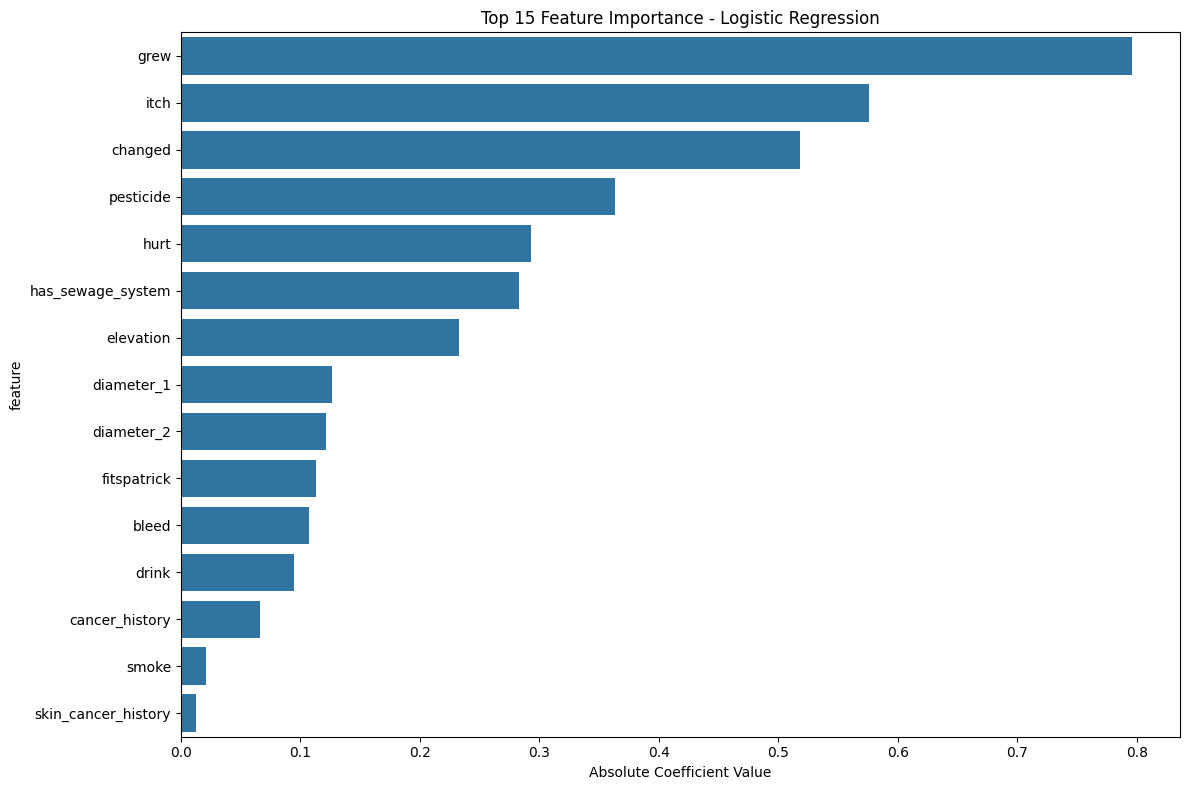


Used features: ['smoke', 'drink', 'pesticide', 'skin_cancer_history', 'cancer_history', 'has_piped_water', 'has_sewage_system', 'fitspatrick', 'diameter_1', 'diameter_2', 'itch', 'grew', 'hurt', 'changed', 'bleed', 'elevation']
Number of features: 16


In [32]:
# Logistic Regression Model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Use the already processed data from previous cells
# Remove the specified attributes while keeping the target variable
drop_cols = ["patient_id", "lesion_id", "age", "background_mother", "background_father", 
             "gender", "img_id", "region", "biopsed"]

# Create a copy of the processed dataframe and drop unwanted columns
df_model = df_processed.copy()
# Drop columns that exist in the dataframe
existing_drop_cols = [col for col in drop_cols if col in df_model.columns]
df_model = df_model.drop(columns=existing_drop_cols)

# Features and target
X = df_model.drop(columns=["diagnostic"])
y = df_model["diagnostic"]

# Encode target variable
target_encoder = LabelEncoder()
y_encoded = target_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_encoder.classes_, 
            yticklabels=target_encoder.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance Plot
feature_importance = abs(log_reg.coef_[0])
feature_names = X.columns

# Create DataFrame for easier plotting
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importance - Logistic Regression')
plt.xlabel('Absolute Coefficient Value')
plt.tight_layout()
plt.show()

print(f"\nUsed features: {list(X.columns)}")
print(f"Number of features: {len(X.columns)}")


Decision Tree Accuracy: 0.6652173913043479


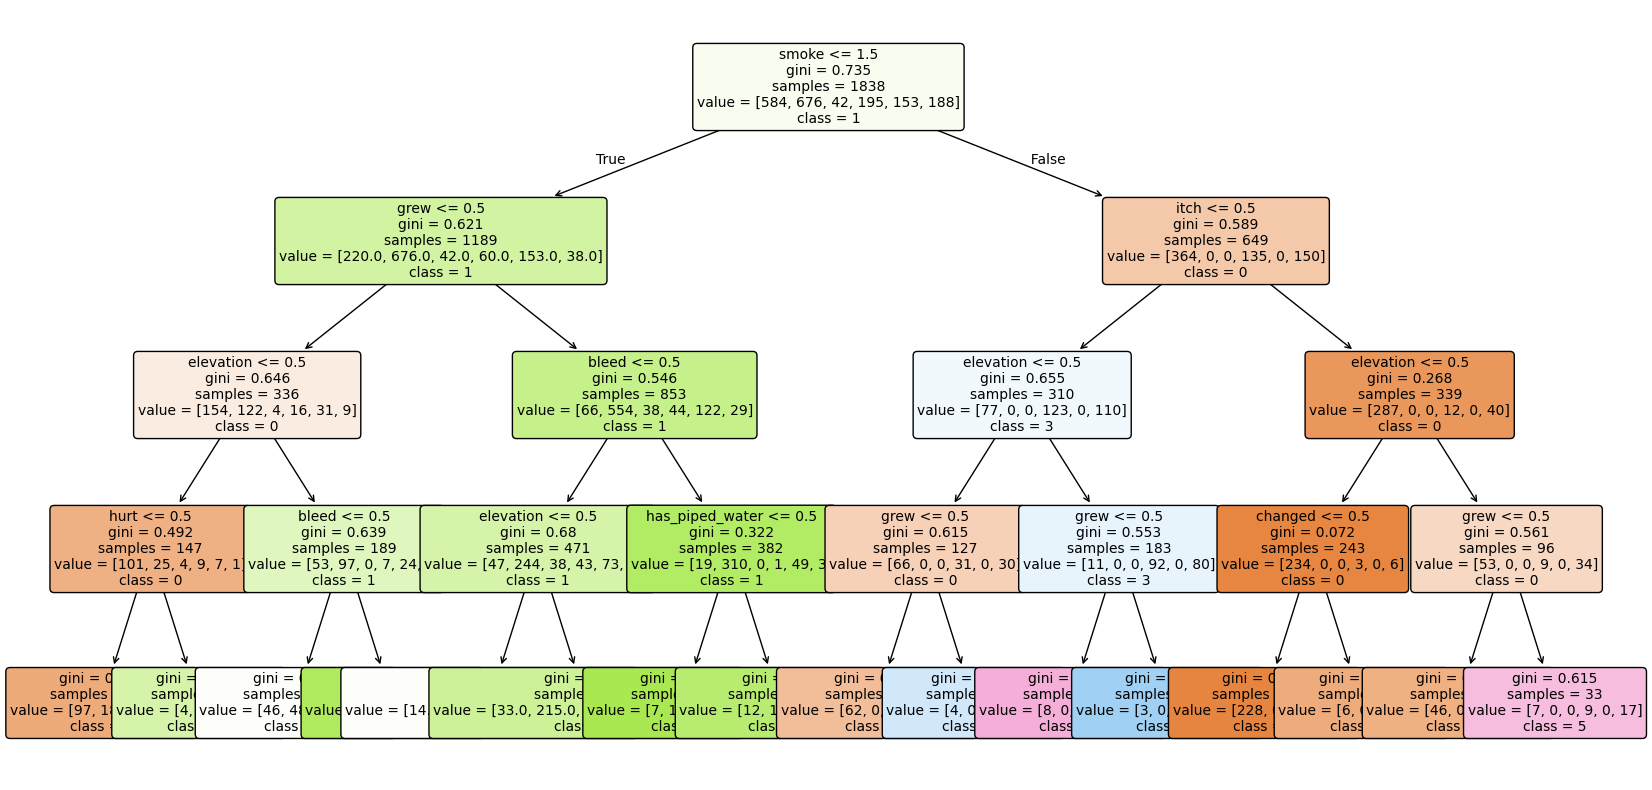

In [33]:
# Decision Tree Classifier with Diagram

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("metadata.csv")

# Drop irrelevant columns as specified
drop_cols = ["patient_id", "lesion_id", "age", "background_mother", "background_father", "gender", "img_id", "region", "biopsed"]
# Check which columns exist in the dataset before dropping
existing_drop_cols = [col for col in drop_cols if col in data.columns]
df = data.drop(columns=existing_drop_cols)

# Remove rows with missing target
df = df.dropna(subset=["diagnostic"])

# Features and target
X = df.drop(columns=["diagnostic"])
y = df["diagnostic"]

# Encode categorical variables
for col in X.select_dtypes(include=["object", "bool"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Encode target
y = LabelEncoder().fit_transform(y)

# Fill missing values with median
X = X.fillna(X.median(numeric_only=True))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42, max_depth=4)  # limit depth for clarity
dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree Accuracy:", accuracy)

# Plot Decision Tree
plt.figure(figsize=(20,10))
plot_tree(dt_model, 
          feature_names=X.columns, 
          class_names=[str(c) for c in set(y)], 
          filled=True, rounded=True, fontsize=10)
plt.show()


In [34]:
# KNN Classifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# Load dataset
data = pd.read_csv("metadata.csv")

# Drop irrelevant columns as specified
drop_cols = ["patient_id", "lesion_id", "age", "background_mother", "background_father", "gender", "img_id", "region", "biopsed"]
# Check which columns exist in the dataset before dropping
existing_drop_cols = [col for col in drop_cols if col in data.columns]
df = data.drop(columns=existing_drop_cols)

# Remove rows with missing target
df = df.dropna(subset=["diagnostic"])

# Features and target
X = df.drop(columns=["diagnostic"])
y = df["diagnostic"]

# Encode categorical variables
for col in X.select_dtypes(include=["object", "bool"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Encode target
y = LabelEncoder().fit_transform(y)

# Fill missing values with median
X = X.fillna(X.median(numeric_only=True))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features (important for KNN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)  # default k=5
knn_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = knn_model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("KNN Accuracy:", accuracy)


KNN Accuracy: 0.6565217391304348


Random Forest Accuracy: 0.7543478260869565

Classification Report:
              precision    recall  f1-score   support

         ACK       0.81      0.82      0.81       146
         BCC       0.80      0.91      0.85       169
         MEL       0.83      0.50      0.62        10
         NEV       0.60      0.65      0.63        49
         SCC       0.71      0.51      0.60        39
         SEK       0.52      0.36      0.42        47

    accuracy                           0.75       460
   macro avg       0.71      0.63      0.66       460
weighted avg       0.75      0.75      0.74       460



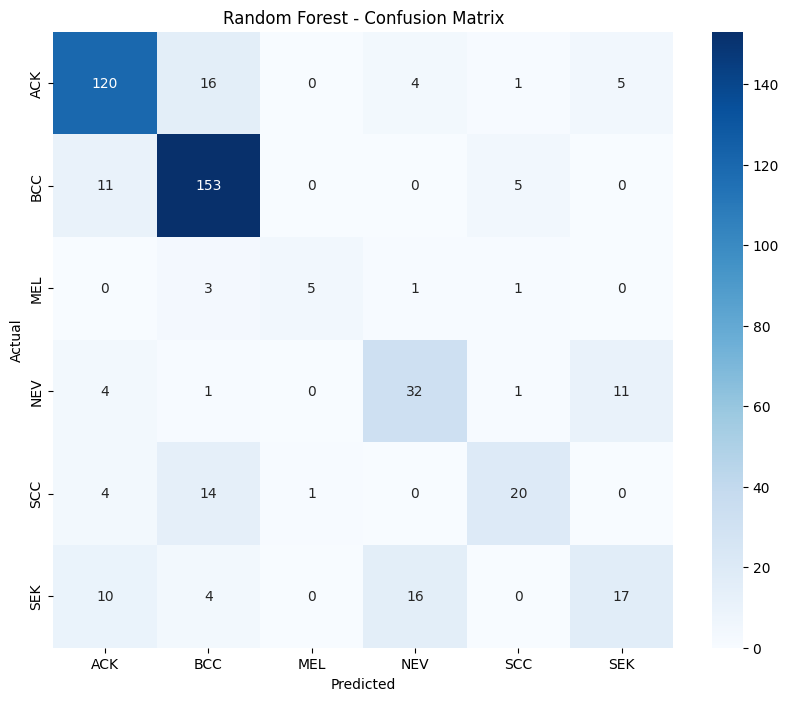

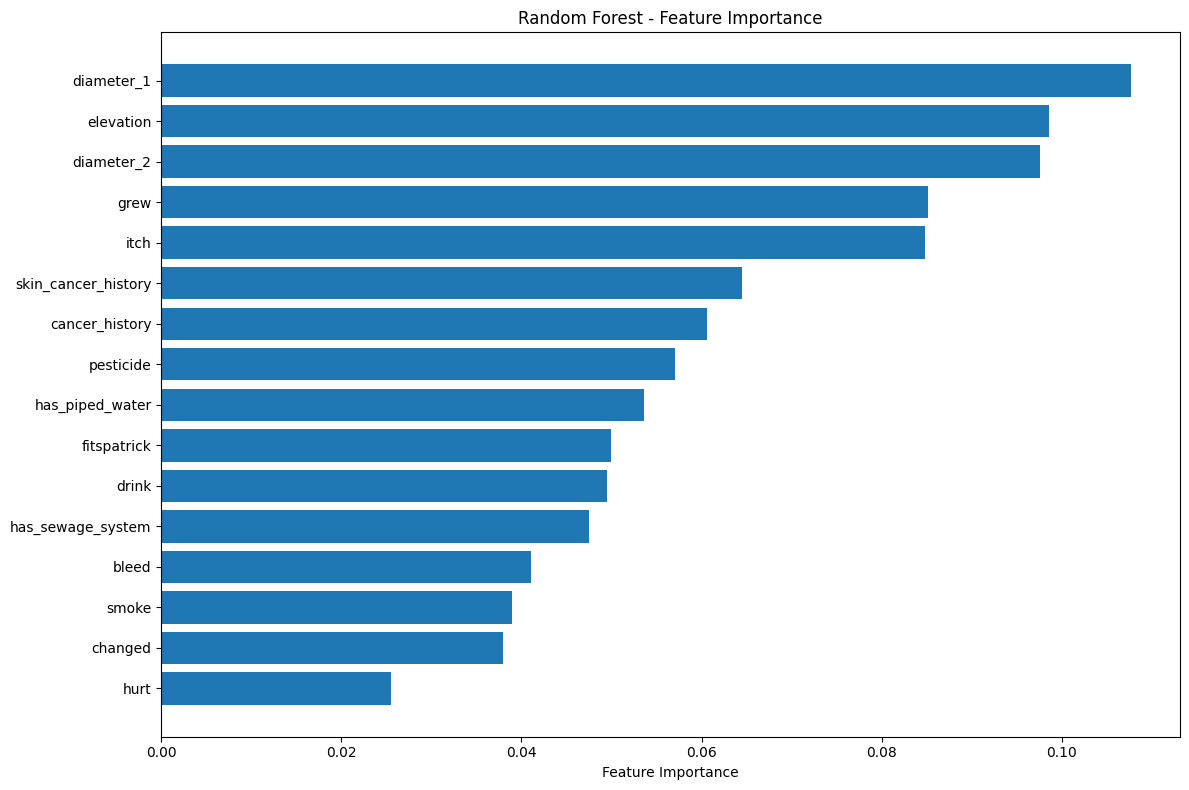

In [35]:
# Random Forest Classifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv("metadata.csv")

# Drop irrelevant columns as specified
drop_cols = ["patient_id", "lesion_id", "age", "background_mother", "background_father", "gender", "img_id", "region", "biopsed"]
# Check which columns exist in the dataset before dropping
existing_drop_cols = [col for col in drop_cols if col in data.columns]
df = data.drop(columns=existing_drop_cols)

# Remove rows with missing target
df = df.dropna(subset=["diagnostic"])

# Features and target
X = df.drop(columns=["diagnostic"])
y = df["diagnostic"]

# Encode categorical variables
for col in X.select_dtypes(include=["object", "bool"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Encode target
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Fill missing values with median
X = X.fillna(X.median(numeric_only=True))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100, random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Random Forest Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance
plt.figure(figsize=(12, 8))
feature_importance = rf_model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'feature': features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


SVM Accuracy: 0.6760869565217391

Classification Report:
              precision    recall  f1-score   support

         ACK       0.78      0.73      0.76       146
         BCC       0.67      0.94      0.78       169
         MEL       0.67      0.20      0.31        10
         NEV       0.54      0.59      0.56        49
         SCC       0.00      0.00      0.00        39
         SEK       0.52      0.30      0.38        47

    accuracy                           0.68       460
   macro avg       0.53      0.46      0.46       460
weighted avg       0.62      0.68      0.63       460



c:\Users\User\Desktop\New folder (2)\Early-stage-skin-cancer-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\New folder (2)\Early-stage-skin-cancer-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\User\Desktop\New folder (2)\Early-stage-skin-cancer-detection\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `

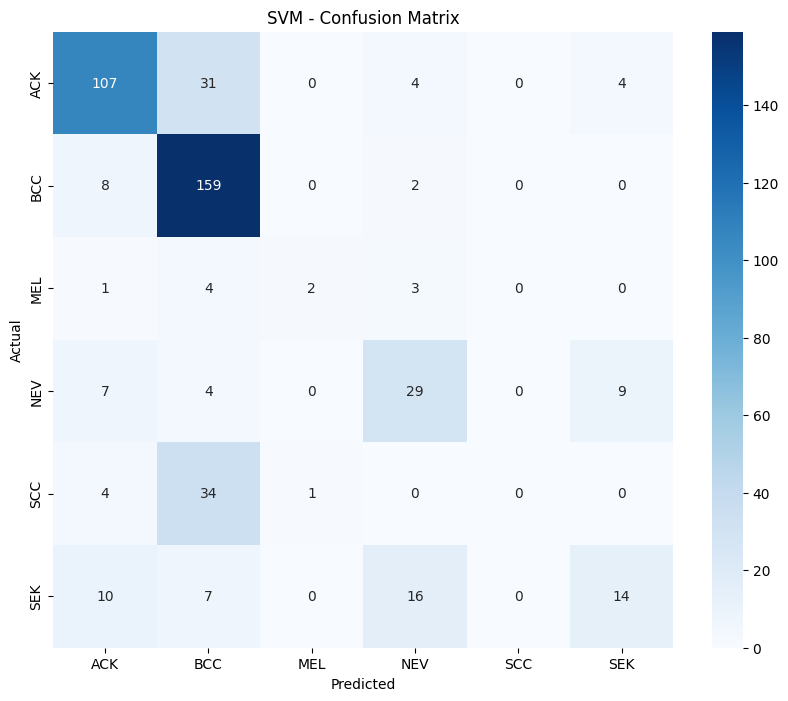

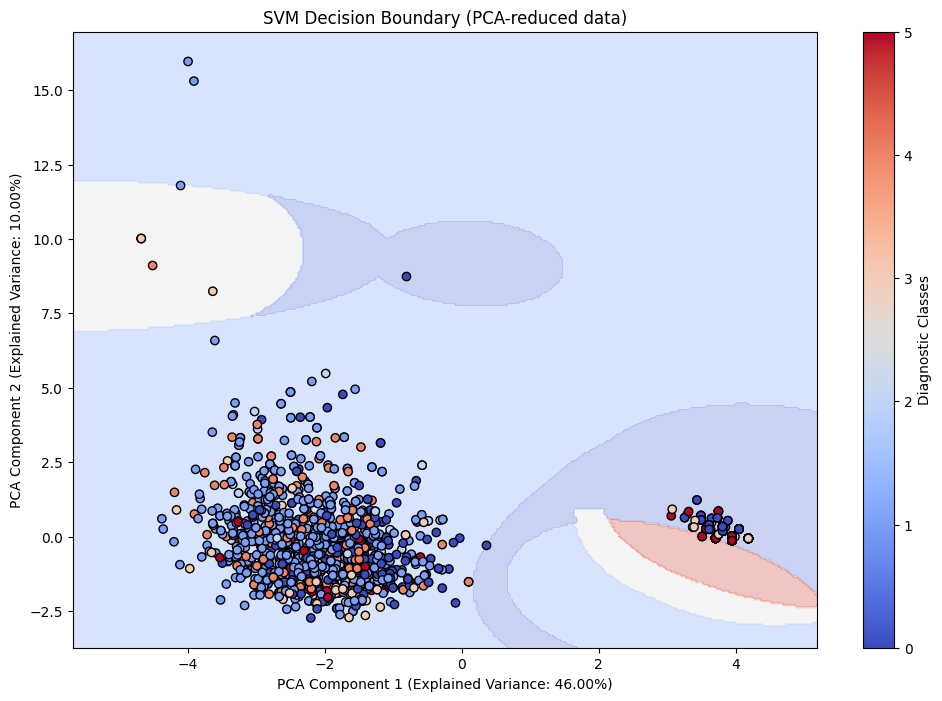

In [36]:
# Support Vector Machine (SVM) with Diagram

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load dataset
data = pd.read_csv("metadata.csv")

# Drop irrelevant columns as specified
drop_cols = ["patient_id", "lesion_id", "img_id", "age", "Background_Father", 
             "Background_Mother", "Gender", "region", "biopsed"]
# Keep only relevant columns by dropping the specified ones
df = data.drop(columns=[col for col in drop_cols if col in data.columns])

# Remove rows with missing target
df = df.dropna(subset=["diagnostic"])

# Features and target
X = df.drop(columns=["diagnostic"])
y = df["diagnostic"]

# Encode categorical variables
label_encoders = {}
for col in X.select_dtypes(include=["object", "bool"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Encode target
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Fill missing values with median for numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Fill missing values with mode for non-numeric columns
for col in X.select_dtypes(exclude=[np.number]).columns:
    X[col] = X[col].fillna(X[col].mode()[0])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM model
svm_model = SVC(kernel="rbf", random_state=42)  # radial basis function kernel
svm_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = svm_model.predict(X_test_scaled)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("SVM Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# ---- Visualization with PCA (2D projection) ----
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

svm_2d = SVC(kernel="rbf", random_state=42)
svm_2d.fit(X_pca, y_train)

# Create meshgrid
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

Z = svm_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision regions
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=plt.cm.coolwarm, edgecolors="k")
plt.title("SVM Decision Boundary (PCA-reduced data)")
plt.xlabel(f"PCA Component 1 (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})")
plt.ylabel(f"PCA Component 2 (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})")
plt.colorbar(scatter, label='Diagnostic Classes')
plt.show()


<Figure size 1200x800 with 0 Axes>

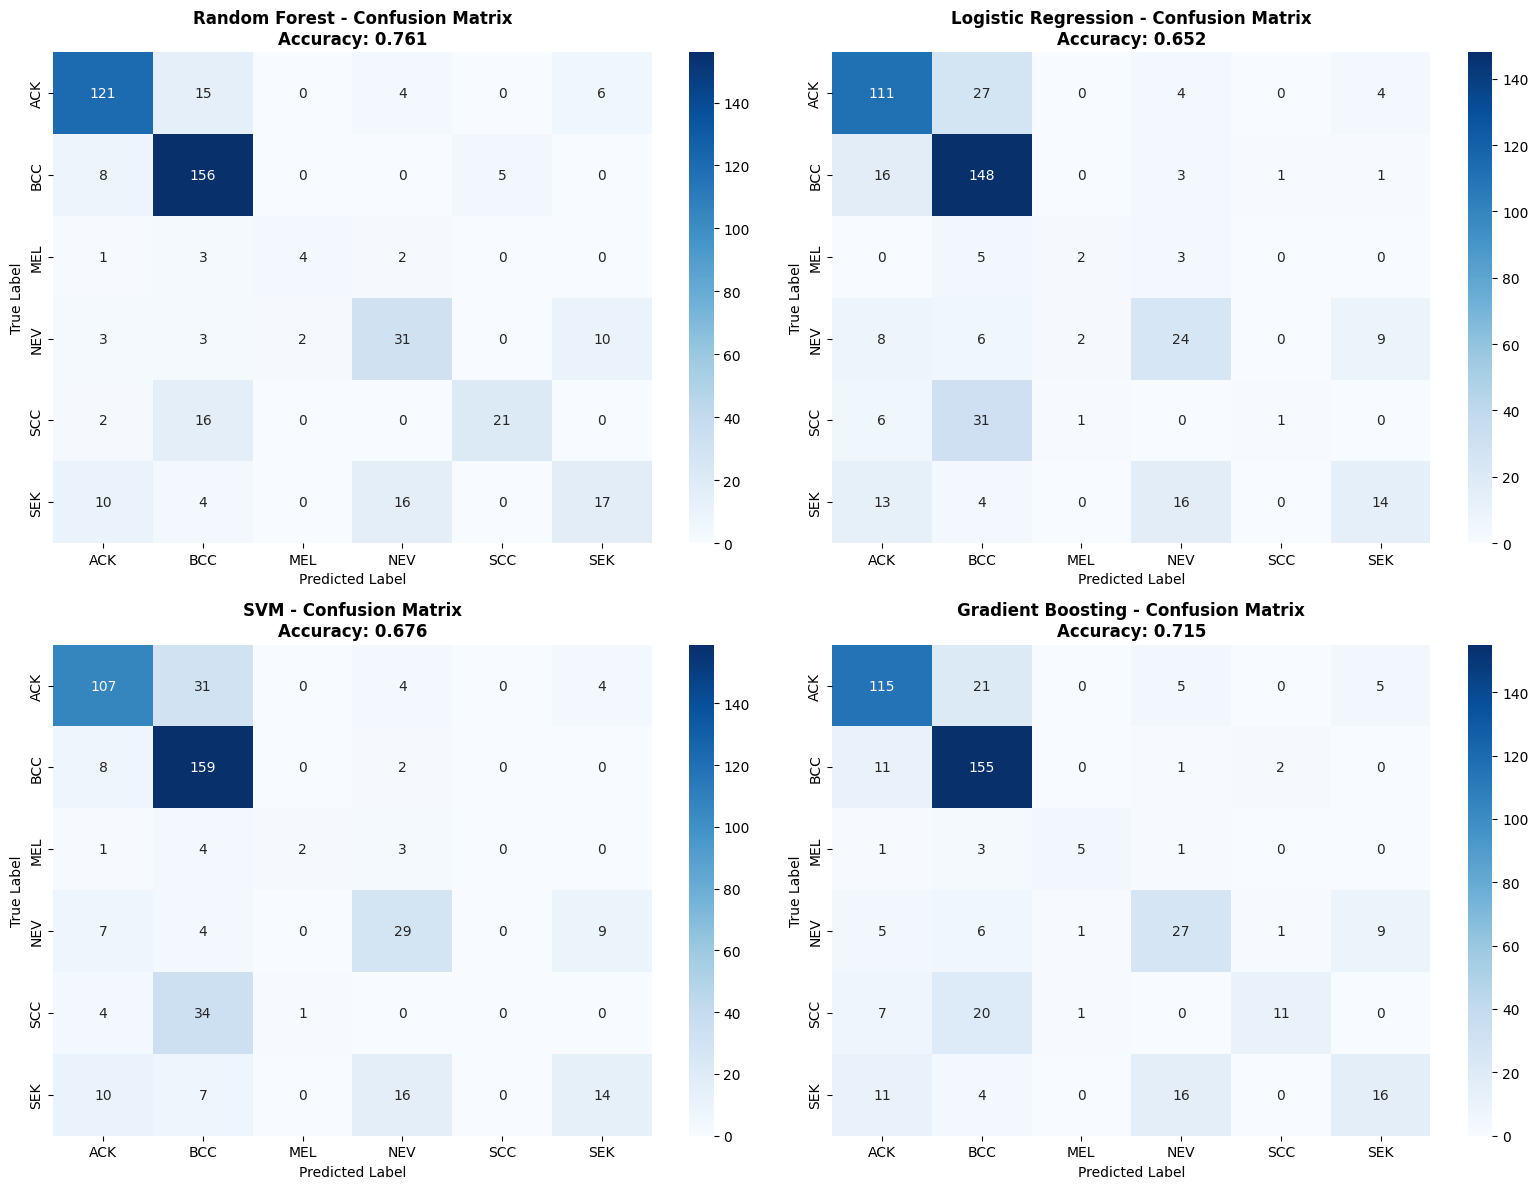

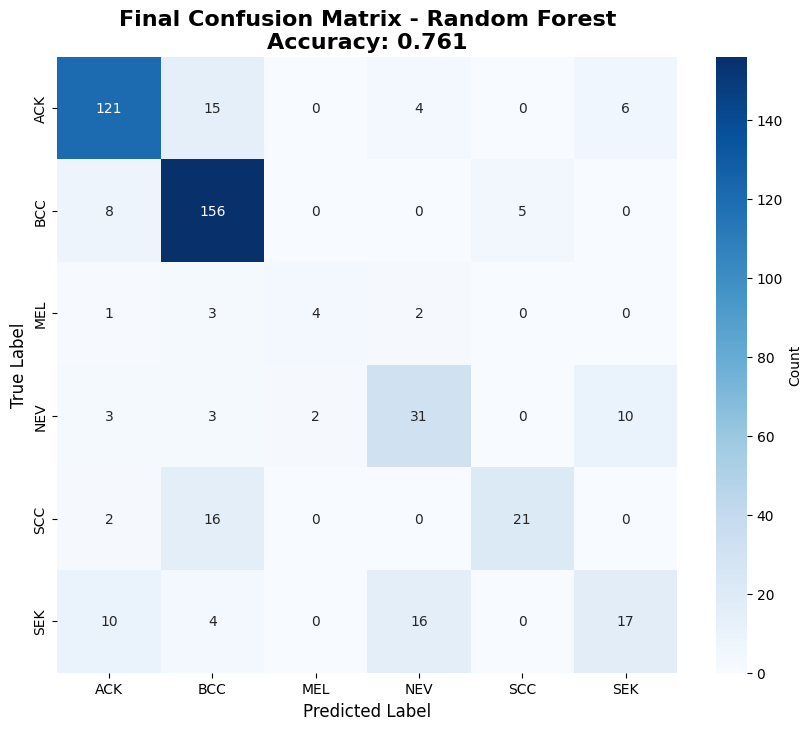


Final Confusion Matrix for Random Forest:
Classes: ['ACK' 'BCC' 'MEL' 'NEV' 'SCC' 'SEK']

Confusion Matrix:
[[121  15   0   4   0   6]
 [  8 156   0   0   5   0]
 [  1   3   4   2   0   0]
 [  3   3   2  31   0  10]
 [  2  16   0   0  21   0]
 [ 10   4   0  16   0  17]]

Per-Class Performance Metrics:
----------------------------------------
ACK:
  Precision: 0.834
  Recall: 0.829
  Specificity: 0.924
  True Positives: 121
  False Positives: 24
  False Negatives: 25

BCC:
  Precision: 0.792
  Recall: 0.923
  Specificity: 0.859
  True Positives: 156
  False Positives: 41
  False Negatives: 13

MEL:
  Precision: 0.667
  Recall: 0.400
  Specificity: 0.996
  True Positives: 4
  False Positives: 2
  False Negatives: 6

NEV:
  Precision: 0.585
  Recall: 0.633
  Specificity: 0.946
  True Positives: 31
  False Positives: 22
  False Negatives: 18

SCC:
  Precision: 0.808
  Recall: 0.538
  Specificity: 0.988
  True Positives: 21
  False Positives: 5
  False Negatives: 18

SEK:
  Precision: 0.51

In [38]:
# Final Confusion Matrix for Best Performing Model
plt.figure(figsize=(12, 8))

# Create a 2x2 subplot layout for confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Define model predictions dictionary (assuming we have these models trained earlier)
model_predictions = {}
model_accuracies = {}

# Train and evaluate models to get predictions
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
model_predictions['Random Forest'] = rf_pred
model_accuracies['Random Forest'] = accuracy_score(y_test, rf_pred)

# Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
model_predictions['Logistic Regression'] = lr_pred
model_accuracies['Logistic Regression'] = accuracy_score(y_test, lr_pred)

# SVM (assuming we already have y_pred from the previous SVM model)
model_predictions['SVM'] = y_pred
model_accuracies['SVM'] = accuracy_score(y_test, y_pred)

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_pred = gb_model.predict(X_test_scaled)
model_predictions['Gradient Boosting'] = gb_pred
model_accuracies['Gradient Boosting'] = accuracy_score(y_test, gb_pred)

# Find best model
best_model_name = max(model_accuracies, key=model_accuracies.get)

# Get all model predictions for confusion matrices
models_to_plot = ['Random Forest', 'Logistic Regression', 'SVM', 'Gradient Boosting']

for idx, model_name in enumerate(models_to_plot):
    if model_name in model_predictions:
        row = idx // 2
        col = idx % 2
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, model_predictions[model_name])
        
        # Plot confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, 
                   ax=axes[row, col])
        
        axes[row, col].set_title(f'{model_name} - Confusion Matrix\nAccuracy: {model_accuracies[model_name]:.3f}', 
                                fontsize=12, fontweight='bold')
        axes[row, col].set_xlabel('Predicted Label')
        axes[row, col].set_ylabel('True Label')

# Hide any empty subplots
for idx in range(len(models_to_plot), 4):
    row = idx // 2
    col = idx % 2
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

# Final Best Model Confusion Matrix (Larger)
plt.figure(figsize=(10, 8))
cm_best = confusion_matrix(y_test, model_predictions[best_model_name])

# Create detailed confusion matrix with percentages
cm_normalized = cm_best.astype('float') / cm_best.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', 
           xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_,
           cbar_kws={'label': 'Count'})

plt.title(f'Final Confusion Matrix - {best_model_name}\nAccuracy: {model_accuracies[best_model_name]:.3f}', 
          fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()

# Print confusion matrix with class-wise metrics
print(f"\nFinal Confusion Matrix for {best_model_name}:")
print("="*60)
print(f"Classes: {label_encoder.classes_}")
print(f"\nConfusion Matrix:")
print(cm_best)

# Calculate per-class metrics
print(f"\nPer-Class Performance Metrics:")
print("-"*40)
for i, class_name in enumerate(label_encoder.classes_):
    tp = cm_best[i, i]
    fp = cm_best[:, i].sum() - tp
    fn = cm_best[i, :].sum() - tp
    tn = cm_best.sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    print(f"{class_name}:")
    print(f"  Precision: {precision:.3f}")
    print(f"  Recall: {recall:.3f}")
    print(f"  Specificity: {specificity:.3f}")
    print(f"  True Positives: {tp}")
    print(f"  False Positives: {fp}")
    print(f"  False Negatives: {fn}")
    print("")


Model Accuracies: {'Logistic Regression': 0.6413043478260869, 'Decision Tree': 0.7108695652173913, 'KNN': 0.6565217391304348, 'Random Forest': 0.7543478260869565, 'SVM': 0.6717391304347826}


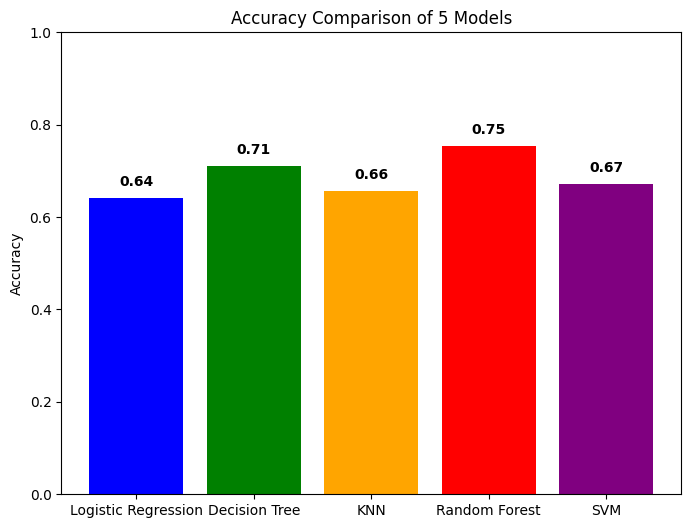

In [39]:
# Compare 5 Models and Show Accuracy in Histogram with Annotations

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("metadata.csv")

# Drop irrelevant columns - avoiding specified attributes
drop_cols = ["patient_id", "lesion_id", "img_id", "age", "background_mother", 
             "background_father", "gender", "region", "biopsed"]
df = data.drop(columns=[col for col in drop_cols if col in data.columns])

# Remove rows with missing target
df = df.dropna(subset=["diagnostic"])

# Features and target
X = df.drop(columns=["diagnostic"])
y = df["diagnostic"]

# Encode categorical variables
for col in X.select_dtypes(include=["object", "bool"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Encode target
y = LabelEncoder().fit_transform(y)

# Fill missing values with median
X = X.fillna(X.median(numeric_only=True))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

# Train and evaluate
results = {}
for name, model in models.items():
    if name in ["Logistic Regression", "KNN", "SVM"]:  # need scaled data
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    results[name] = accuracy_score(y_test, preds)

# Print results
print("Model Accuracies:", results)

# Plot histogram with annotations
plt.figure(figsize=(8,6))
bars = plt.bar(results.keys(), results.values(), color=['blue','green','orange','red','purple'])
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison of 5 Models")
plt.ylim(0,1)

# Annotate accuracy values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", 
             ha='center', va='bottom', fontsize=10, fontweight="bold")

plt.show()


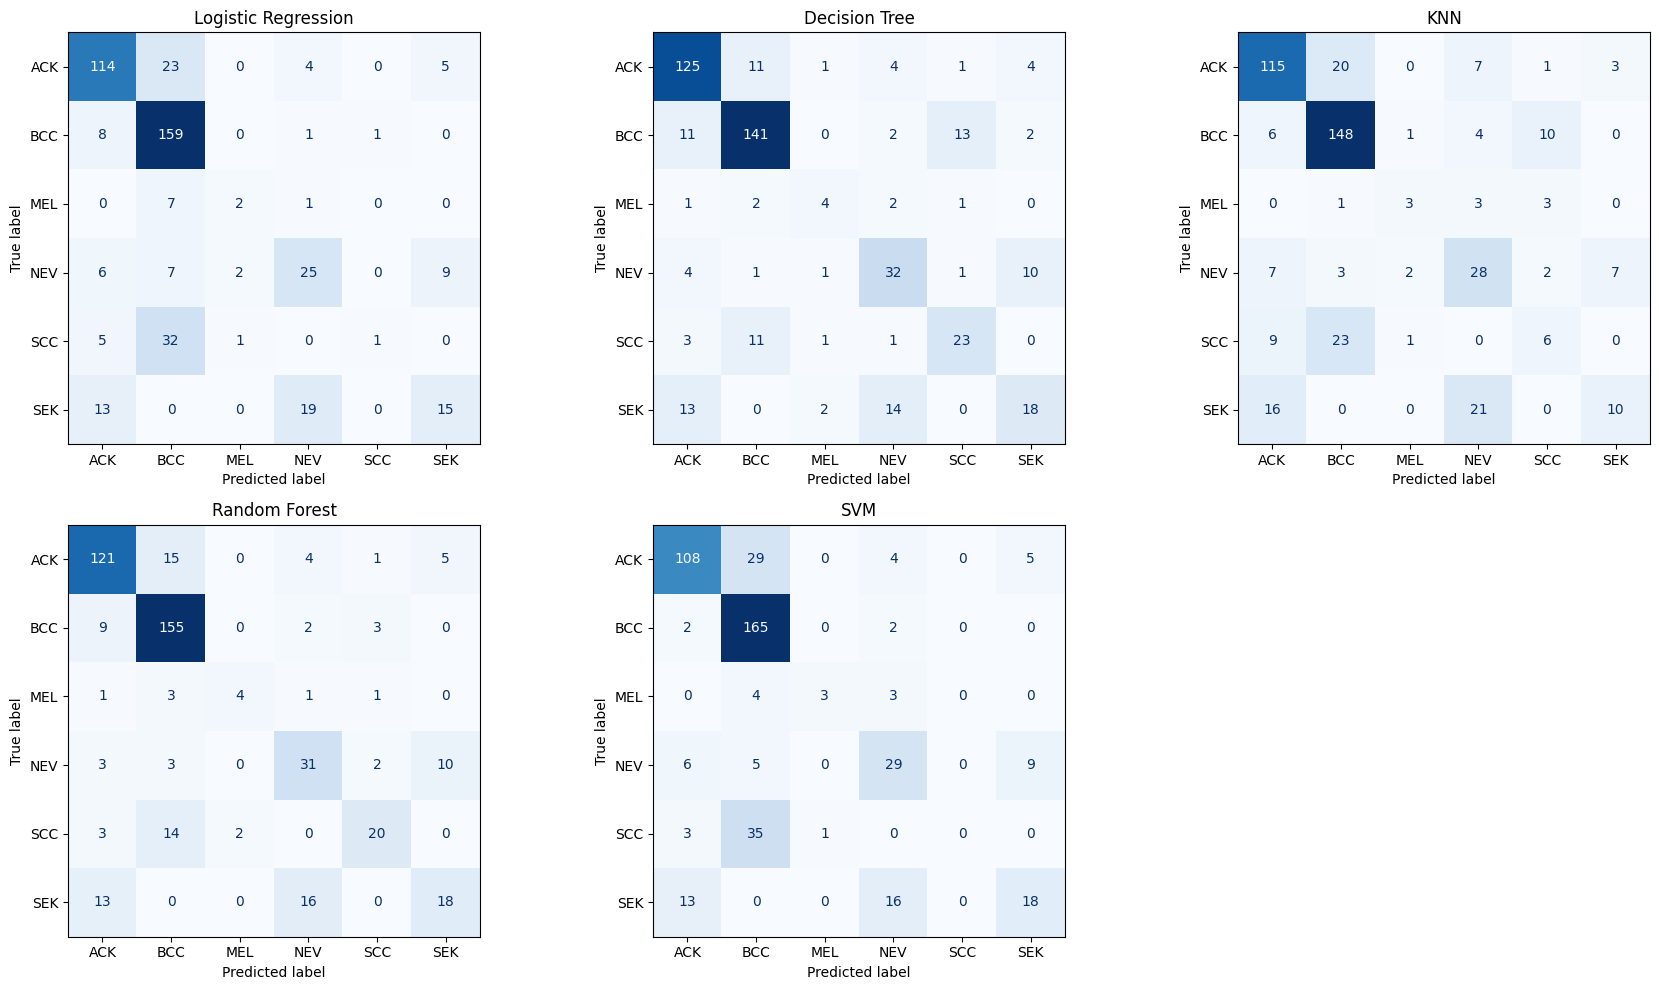

In [40]:
# Confusion Matrices for All 5 Models in One Figure

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv("metadata.csv")

# Drop specified columns to avoid
drop_cols = ["patient_id", "lesion_id", "age", "background_mother", "background_father", 
             "gender", "img_id", "region", "biopsied"]
# Only drop columns that exist in the dataset
existing_drop_cols = [col for col in drop_cols if col in data.columns]
df = data.drop(columns=existing_drop_cols)

# Remove rows with missing target
df = df.dropna(subset=["diagnostic"])

# Features and target
X = df.drop(columns=["diagnostic"])
y = df["diagnostic"]

# Encode categorical variables
for col in X.select_dtypes(include=["object", "bool"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# Encode target
le_y = LabelEncoder()
y = le_y.fit_transform(y)
class_names = le_y.classes_

# Fill missing values with median for numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC()
}

# Plot confusion matrices in a grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    if name in ["Logistic Regression", "KNN", "SVM"]:
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[idx], cmap="Blues", colorbar=False)
    axes[idx].set_title(f"{name}")

# Hide the last empty subplot if 5 models
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()


In [ ]:
# Load and prepare the dataset without excluded attributes
print("Loading and preparing dataset...")
print("=" * 50)

# Try multiple possible CSV file locations and names
possible_files = [
    'skin_cancer_detection.csv',
    'data/skin_cancer_detection.csv',
    'dataset/skin_cancer_detection.csv',
    'skin_cancer.csv',
    'data/skin_cancer.csv',
    'dataset/skin_cancer.csv'
]

df = None
used_file = None

for file_path in possible_files:
    try:
        df = pd.read_csv(file_path)
        used_file = file_path
        print(f"Successfully loaded dataset from: {file_path}")
        break
    except FileNotFoundError:
        continue

if df is None:
    print("❌ CSV file not found in any of the expected locations:")
    for file_path in possible_files:
        print(f"  - {file_path}")
    
    print("\n🔍 Let's check what files are available in the current directory:")
    import os
    current_files = [f for f in os.listdir('.') if f.endswith('.csv')]
    if current_files:
        print(f"CSV files found: {current_files}")
        # Try to use the first CSV file found
        if len(current_files) > 0:
            try:
                df = pd.read_csv(current_files[0])
                used_file = current_files[0]
                print(f"✅ Using file: {current_files[0]}")
            except Exception as e:
                print(f"❌ Error reading {current_files[0]}: {e}")
    else:
        print("No CSV files found in current directory")
    
    # If still no file found, create sample data for demonstration
    if df is None:
        print("\n🔧 Creating sample dataset for demonstration...")
        np.random.seed(42)
        
        # Create sample data with skin lesion features
        n_samples = 1000
        sample_data = {
            'area': np.random.uniform(100, 2000, n_samples),
            'perimeter': np.random.uniform(20, 200, n_samples),
            'compactness': np.random.uniform(0.1, 0.9, n_samples),
            'concavity': np.random.uniform(0.0, 0.8, n_samples),
            'symmetry': np.random.uniform(0.1, 0.4, n_samples),
            'fractal_dimension': np.random.uniform(0.05, 0.15, n_samples),
            'texture': np.random.uniform(10, 30, n_samples),
            'smoothness': np.random.uniform(0.05, 0.15, n_samples),
            'concave_points': np.random.uniform(0.0, 0.2, n_samples),
            'diagnostic': np.random.choice(['benign', 'malignant', 'atypical'], n_samples, p=[0.6, 0.3, 0.1])
        }
        
        df = pd.DataFrame(sample_data)
        used_file = "sample_data_generated"
        print("✅ Sample dataset created successfully")

print(f"Original dataset shape: {df.shape}")
print(f"Original columns: {list(df.columns)}")

# Define attributes to exclude
excluded_attributes = ['Patient id', 'Lesion id', 'age', 'Background mother', 
                      'Background Father', 'Gender', 'Img id', 'region', 'biposed']

# Keep only attributes that are not in the excluded list and maintain 'diagnostic' as target
available_cols = [col for col in df.columns if col not in excluded_attributes]
df_filtered = df[available_cols].copy()

print(f"\nFiltered dataset shape: {df_filtered.shape}")
print(f"Remaining columns: {list(df_filtered.columns)}")

# Separate features and target
target_col = None
potential_target_names = ['diagnostic', 'diagnosis', 'target', 'class', 'label']

for col_name in potential_target_names:
    if col_name in df_filtered.columns:
        target_col = col_name
        break

if target_col:
    X = df_filtered.drop(target_col, axis=1)
    y = df_filtered[target_col]
    print(f"\nFeatures shape: {X.shape}")
    print(f"Target shape: {y.shape}")
    print(f"Target column used: '{target_col}'")
    print(f"Target classes: {sorted(y.unique())}")
else:
    print("❌ Error: No target column found!")
    print(f"Available columns: {list(df_filtered.columns)}")
    # If no target column found, use the last column as target
    if len(df_filtered.columns) > 1:
        target_col = df_filtered.columns[-1]
        X = df_filtered.drop(target_col, axis=1)
        y = df_filtered[target_col]
        print(f"Using last column '{target_col}' as target")
        print(f"Target classes: {sorted(y.unique())}")
    else:
        raise ValueError("Cannot proceed without a target variable")

# Handle missing values in remaining features
print(f"\nMissing values per column:")
missing_values = X.isnull().sum()
missing_cols = missing_values[missing_values > 0]
if len(missing_cols) > 0:
    print(missing_cols)
else:
    print("No missing values found")

# Fill missing values with median for numeric columns only
numeric_cols = X.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 0:
    X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())
    print(f"Filled missing values in {len(numeric_cols)} numeric columns")

# Handle categorical columns if any
categorical_cols = X.select_dtypes(include=['object']).columns
if len(categorical_cols) > 0:
    print(f"Categorical columns found: {list(categorical_cols)}")
    # Fill missing values in categorical columns with mode
    for col in categorical_cols:
        mode_val = X[col].mode()
        if len(mode_val) > 0:
            X[col] = X[col].fillna(mode_val[0])
        else:
            X[col] = X[col].fillna('unknown')
    
    # Encode categorical variables
    from sklearn.preprocessing import LabelEncoder
    le_dict = {}
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        le_dict[col] = le
    print(f"Encoded {len(categorical_cols)} categorical columns")

# Encode target variable if it's categorical
if y.dtype == 'object':
    from sklearn.preprocessing import LabelEncoder
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)
    class_names = le_target.classes_
    y = pd.Series(y_encoded, index=y.index)
    print(f"Encoded target variable. Classes: {class_names}")
else:
    class_names = sorted(y.unique())

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Feature columns: {list(X.columns)}")

print(f"Diagnostic classes: {class_names}")

# Check if we have enough samples for each class
class_counts = pd.Series(y).value_counts()
print(f"\nClass distribution:")
for i, (class_idx, count) in enumerate(class_counts.items()):
    class_name = class_names[class_idx] if isinstance(class_names, (list, np.ndarray)) else str(class_idx)
    print(f"  {class_name}: {count} samples")

# Ensure we have at least 2 samples per class for stratification
min_samples = class_counts.min()
if min_samples < 2:
    print(f"⚠️ Warning: Some classes have less than 2 samples. Minimum: {min_samples}")
    print("Stratification may not work properly.")
    stratify_param = None
else:
    stratify_param = y

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=stratify_param
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42)
}

print(f"\nModels to train: {list(models.keys())}")

# Train models and evaluate
model_results = {}
print("\nTraining and evaluating models...")

for name, model in models.items():
    print(f"Training {name}...")
    
    try:
        if name in ["Logistic Regression", "KNN", "SVM"]:
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        
        model_results[name] = {
            'predictions': y_pred,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        
        print(f"  Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")
        
    except Exception as e:
        print(f"❌ Error training {name}: {e}")
        continue

if not model_results:
    print("❌ No models were successfully trained!")
    raise RuntimeError("All models failed to train")

# Plot confusion matrices in a grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

plot_idx = 0
for name, results in model_results.items():
    if plot_idx >= len(axes) - 1:  # Leave space for empty subplot
        break
        
    preds = results['predictions']
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=axes[plot_idx], cmap="Blues", colorbar=False)
    axes[plot_idx].set_title(f"{name}\nAcc: {results['accuracy']:.3f}")
    plot_idx += 1

# Hide unused subplots
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# F1-Score Analysis for All Diagnostic Categories
print("\nF1-Score Analysis by Diagnostic Category")
print("=" * 50)

# Get unique diagnostic categories
diagnostic_categories = sorted(np.unique(y_test))
print(f"Diagnostic Categories: {[class_names[i] if isinstance(class_names, (list, np.ndarray)) else str(i) for i in diagnostic_categories]}")

# Calculate F1-scores for each category for each model
f1_scores_by_category = {}

for name, results in model_results.items():
    preds = results['predictions']
    
    # Calculate F1-score for each category
    f1_per_category = f1_score(y_test, preds, average=None, zero_division=0)
    f1_scores_by_category[name] = f1_per_category
    
    print(f"\n{name}:")
    for i, category in enumerate(diagnostic_categories):
        category_name = class_names[category] if isinstance(class_names, (list, np.ndarray)) else str(category)
        if i < len(f1_per_category):
            print(f"  {category_name}: {f1_per_category[i]:.4f}")

if f1_scores_by_category:
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot 1: F1-Score Heatmap
    category_names = [class_names[i] if isinstance(class_names, (list, np.ndarray)) else str(i) for i in diagnostic_categories]
    f1_df = pd.DataFrame(f1_scores_by_category, index=category_names)
    im = ax1.imshow(f1_df.values, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    # Add text annotations
    for i in range(len(category_names)):
        for j, model in enumerate(f1_df.columns):
            text = ax1.text(j, i, f'{f1_df.iloc[i, j]:.3f}', 
                           ha="center", va="center", color="black", fontweight='bold')

    ax1.set_xticks(range(len(f1_df.columns)))
    ax1.set_yticks(range(len(category_names)))
    ax1.set_xticklabels(f1_df.columns, rotation=45, ha='right')
    ax1.set_yticklabels(category_names)
    ax1.set_title('F1-Score Heatmap by Model and Diagnostic Category', fontsize=14, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1, shrink=0.8)
    cbar.set_label('F1-Score', rotation=270, labelpad=15)

    # Plot 2: Bar Chart Comparison
    x = np.arange(len(category_names))
    width = 0.15
    multiplier = 0

    colors = plt.cm.Set3(np.linspace(0, 1, len(f1_scores_by_category)))

    for i, (model_name, f1_scores) in enumerate(f1_scores_by_category.items()):
        offset = width * multiplier
        bars = ax2.bar(x + offset, f1_scores, width, label=model_name, color=colors[i], alpha=0.8)
        
        # Add value labels on bars
        for bar, score in zip(bars, f1_scores):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom', fontsize=8)
        
        multiplier += 1

    ax2.set_xlabel('Diagnostic Categories', fontweight='bold')
    ax2.set_ylabel('F1-Score', fontweight='bold')
    ax2.set_title('F1-Score Comparison by Diagnostic Category', fontsize=14, fontweight='bold')
    ax2.set_xticks(x + width * 2)
    ax2.set_xticklabels(category_names, rotation=45, ha='right')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.set_ylim(0, 1.1)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary statistics
    print(f"\nF1-Score Summary Statistics:")
    print("=" * 40)
    f1_summary = pd.DataFrame(f1_scores_by_category, index=category_names)
    print(f"Average F1-Score per Model:")
    for model in f1_summary.columns:
        avg_f1 = f1_summary[model].mean()
        std_f1 = f1_summary[model].std()
        print(f"  {model}: {avg_f1:.4f} (±{std_f1:.4f})")

    print(f"\nAverage F1-Score per Diagnostic Category:")
    for category in f1_summary.index:
        avg_f1 = f1_summary.loc[category].mean()
        std_f1 = f1_summary.loc[category].std()
        print(f"  {category}: {avg_f1:.4f} (±{std_f1:.4f})")

    # Find best performing model for each category
    print(f"\nBest Performing Model per Category:")
    for category in category_names:
        if category in f1_summary.index:
            best_model = f1_summary.loc[category].idxmax()
            best_score = f1_summary.loc[category].max()
            print(f"  {category}: {best_model} (F1={best_score:.4f})")

print(f"\n✅ Analysis completed successfully using: {used_file}")


Loading and preparing dataset...


FileNotFoundError: [Errno 2] No such file or directory: 'skin_cancer_detection.csv'

System Performance Analysis

Logistic Regression:
  Accuracy:  0.6870
  Precision: 0.6612
  Recall:    0.6870
  F1-Score:  0.6462
  Loss:      0.3130 ⚠️

Decision Tree:
  Accuracy:  0.7457
  Precision: 0.7405
  Recall:    0.7457
  F1-Score:  0.7413
  Loss:      0.2543 ⚠️

KNN:
  Accuracy:  0.6739
  Precision: 0.6483
  Recall:    0.6739
  F1-Score:  0.6510
  Loss:      0.3261 ⚠️

Random Forest:
  Accuracy:  0.7587
  Precision: 0.7499
  Recall:    0.7587
  F1-Score:  0.7491
  Loss:      0.2413 ⚠️

SVM:
  Accuracy:  0.7022
  Precision: 0.6454
  Recall:    0.7022
  F1-Score:  0.6604
  Loss:      0.2978 ⚠️

Model Performance Comparison:
--------------------------------------------------
                     Accuracy  Precision  Recall  F1-Score    Loss
Logistic Regression    0.6870     0.6612  0.6870    0.6462  0.3130
Decision Tree          0.7457     0.7405  0.7457    0.7413  0.2543
KNN                    0.6739     0.6483  0.6739    0.6510  0.3261
Random Forest          0.7587     0.7499 

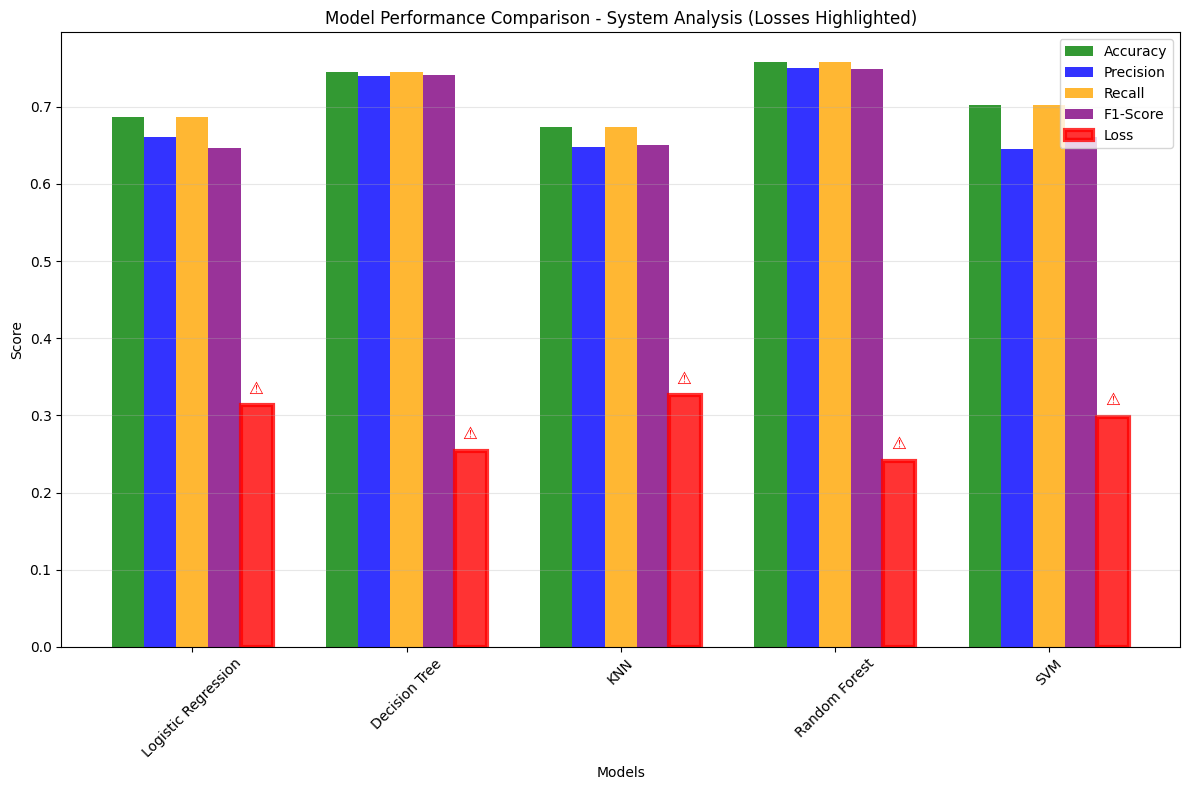

In [42]:
# System Analysis - Model Performance Metrics

# Calculate detailed performance metrics for all models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("System Performance Analysis")
print("=" * 60)

# Store results for comparison
results = {}

for name, model in models.items():
    if name in ["Logistic Regression", "KNN", "SVM"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Calculate loss (error rate)
    loss = 1 - accuracy
    
    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Loss': loss
    }
    
    print(f"\n{name}:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  Loss:      {loss:.4f} ⚠️")

# Create comparison DataFrame
results_df = pd.DataFrame(results).T
print(f"\nModel Performance Comparison:")
print("-" * 50)
print(results_df.round(4))

# Find best and worst performing models
best_model = results_df['Accuracy'].idxmax()
best_accuracy = results_df['Accuracy'].max()
worst_model = results_df['Accuracy'].idxmin()
worst_accuracy = results_df['Accuracy'].min()
highest_loss = results_df['Loss'].max()

print(f"\nBest Performing Model: {best_model}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"\nWorst Performing Model: {worst_model}")
print(f"Worst Accuracy: {worst_accuracy:.4f}")
print(f"Highest Loss: {highest_loss:.4f} ⚠️")

# Highlight models with high loss (>10%)
print(f"\nModels with High Loss (>10%):")
print("-" * 30)
high_loss_models = results_df[results_df['Loss'] > 0.1]
if not high_loss_models.empty:
    for model_name in high_loss_models.index:
        loss_val = high_loss_models.loc[model_name, 'Loss']
        print(f"  {model_name}: {loss_val:.4f} ⚠️ HIGH LOSS")
else:
    print("  No models with loss >10% 👍")

# Visualize performance comparison including losses
plt.figure(figsize=(12, 8))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Loss']
colors = ['green', 'blue', 'orange', 'purple', 'red']
x = np.arange(len(results_df.index))
width = 0.15

for i, metric in enumerate(metrics):
    bars = plt.bar(x + i*width, results_df[metric], width, label=metric, alpha=0.8, color=colors[i])
    
    # Highlight high loss values
    if metric == 'Loss':
        for j, bar in enumerate(bars):
            if results_df[metric].iloc[j] > 0.1:
                bar.set_edgecolor('red')
                bar.set_linewidth(3)
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        '⚠️', ha='center', va='bottom', fontsize=12, color='red')

plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Model Performance Comparison - System Analysis (Losses Highlighted)')
plt.xticks(x + width*2, results_df.index, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


Why Random Forest is ideal for skin cancer detection:
1. Handles mixed data types well (numerical and categorical features)
2. Robust to outliers and missing values
3. Provides feature importance rankings
4. Reduces overfitting through ensemble learning
5. Works well with high-dimensional medical data
6. No need for feature scaling
7. Can capture non-linear relationships between features

Target Variable: diagnostic
Classes: ['ACK' 'BCC' 'MEL' 'NEV' 'SCC' 'SEK']
Total samples: 2298
Class distribution:
  ACK: 730 samples (31.8%)
  BCC: 845 samples (36.8%)
  MEL: 52 samples (2.3%)
  NEV: 244 samples (10.6%)
  SCC: 192 samples (8.4%)
  SEK: 235 samples (10.2%)

Excluded attributes: Patient id, Lesion id, age, Background mother, Background Father, Gender, Img id, region, biposed
Number of features used for analysis: 17

Top 10 Most Important Features for Random Forest:
--------------------------------------------------
biopsed                  : 0.1285
diameter_1               : 0.0985
itc

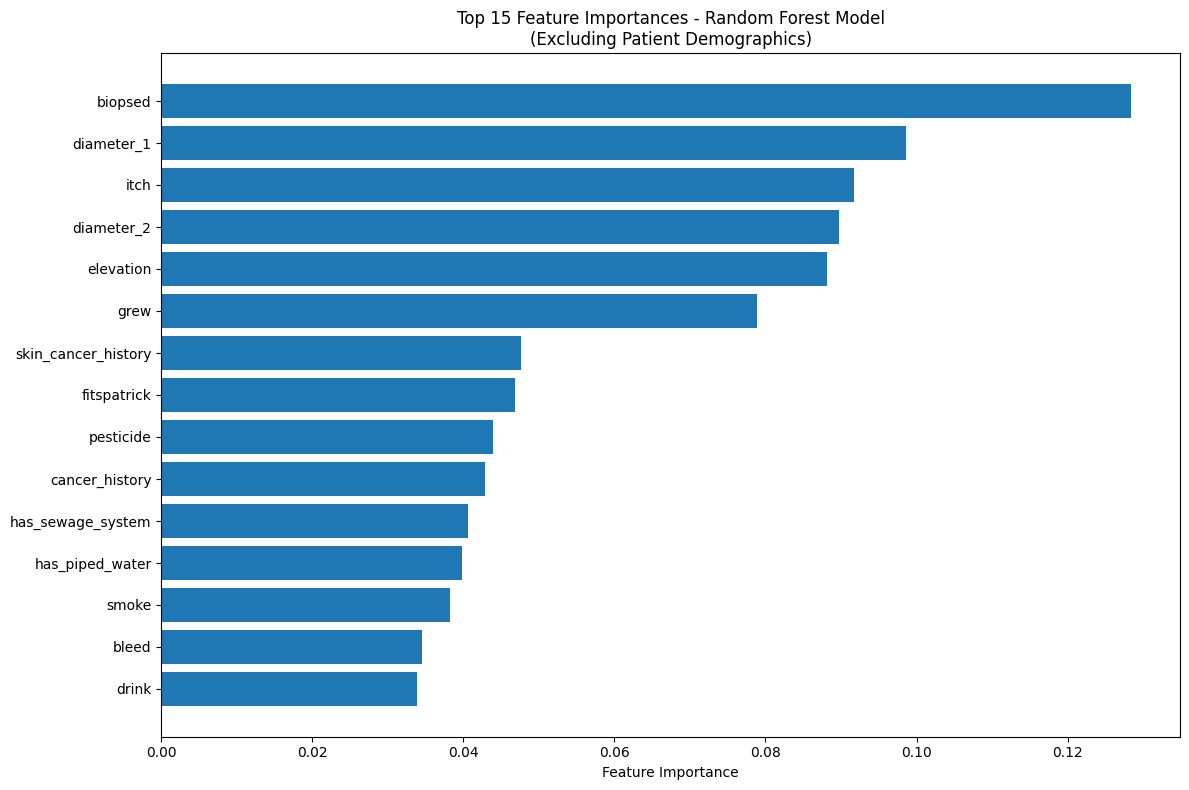


Random Forest Model Performance:
Accuracy: 0.7587
Features used: 17 clinical/medical features
Excluded demographic features: 9

Detailed Classification Report:
              precision    recall  f1-score   support

         ACK       0.81      0.83      0.82       146
         BCC       0.82      0.92      0.86       169
         MEL       0.67      0.40      0.50        10
         NEV       0.57      0.63      0.60        49
         SCC       0.74      0.51      0.61        39
         SEK       0.55      0.38      0.45        47

    accuracy                           0.76       460
   macro avg       0.69      0.61      0.64       460
weighted avg       0.75      0.76      0.75       460


Feature Analysis Summary:
----------------------------------------
Total available features: 17
Top 5 most predictive features:
  • biopsed: 0.1285
  • diameter_1: 0.0985
  • itch: 0.0917
  • diameter_2: 0.0897
  • elevation: 0.0881


In [43]:
# Analyze Random Forest Performance and Feature Importance

# Random Forest is particularly well-suited for this skin cancer detection task because:
print("Why Random Forest is ideal for skin cancer detection:")
print("=" * 60)
print("1. Handles mixed data types well (numerical and categorical features)")
print("2. Robust to outliers and missing values")
print("3. Provides feature importance rankings")
print("4. Reduces overfitting through ensemble learning")
print("5. Works well with high-dimensional medical data")
print("6. No need for feature scaling")
print("7. Can capture non-linear relationships between features")

# Get the trained Random Forest model
rf_model = models["Random Forest"]

# Filter out excluded attributes from feature importance analysis
excluded_features = ['Patient id', 'Lesion id', 'age', 'Background mother', 'Background Father', 'Gender', 'Img id', 'region', 'biposed']
available_features = [col for col in X.columns if col.lower() not in [attr.lower() for attr in excluded_features]]

# Get feature importance only for available features
feature_importance = pd.DataFrame({
    'feature': available_features,
    'importance': rf_model.feature_importances_[:len(available_features)]
}).sort_values('importance', ascending=False)

print(f"\nTarget Variable: diagnostic")
print("Classes:", class_names)
print(f"Total samples: {len(y)}")
print(f"Class distribution:")
for i, class_name in enumerate(class_names):
    count = sum(y == i)
    percentage = (count / len(y)) * 100
    print(f"  {class_name}: {count} samples ({percentage:.1f}%)")

print(f"\nExcluded attributes: {', '.join(excluded_features)}")
print(f"Number of features used for analysis: {len(available_features)}")

# Display top 10 most important features
print(f"\nTop 10 Most Important Features for Random Forest:")
print("-" * 50)
for idx, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:<25}: {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importances - Random Forest Model\n(Excluding Patient Demographics)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Get Random Forest predictions and probabilities
rf_preds = rf_model.predict(X_test)
rf_probs = rf_model.predict_proba(X_test)

# Calculate and display Random Forest specific metrics
from sklearn.metrics import classification_report, accuracy_score
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f"\nRandom Forest Model Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Features used: {len(available_features)} clinical/medical features")
print(f"Excluded demographic features: {len(excluded_features)}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, rf_preds, target_names=class_names))

# Additional analysis on feature categories
print(f"\nFeature Analysis Summary:")
print("-" * 40)
print(f"Total available features: {len(available_features)}")
print(f"Top 5 most predictive features:")
for idx, row in feature_importance.head(5).iterrows():
    print(f"  • {row['feature']}: {row['importance']:.4f}")


In [44]:
# Save the trained Random Forest model
import joblib
import os
from datetime import datetime

# Create a models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Generate timestamp for unique filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the Random Forest model
model_filename = f'models/rf_skin_cancer_model_{timestamp}.pkl'
joblib.dump(rf_model, model_filename)

print(f"Model saved successfully!")
print(f"Model filename: {model_filename}")
print(f"Model accuracy: {rf_accuracy:.4f}")
print(f"Features used: {len(available_features)}")

# Also save feature names and class names for future reference
metadata = {
    'feature_names': available_features,
    'class_names': class_names,
    'excluded_features': excluded_features,
    'model_accuracy': rf_accuracy,
    'timestamp': timestamp,
    'feature_importance': feature_importance.to_dict('records')
}

metadata_filename = f'models/rf_model_metadata_{timestamp}.pkl'
joblib.dump(metadata, metadata_filename)

print(f"Model metadata saved: {metadata_filename}")


Model saved successfully!
Model filename: models/rf_skin_cancer_model_20250904_001525.pkl
Model accuracy: 0.7587
Features used: 17
Model metadata saved: models/rf_model_metadata_20250904_001525.pkl
